# Import packages

In [167]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from random import random

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Set figure parameters
plt.rcParams['figure.figsize'] = [10, 7.5]

# Input datasets

[*********************100%%**********************]  1 of 1 completed


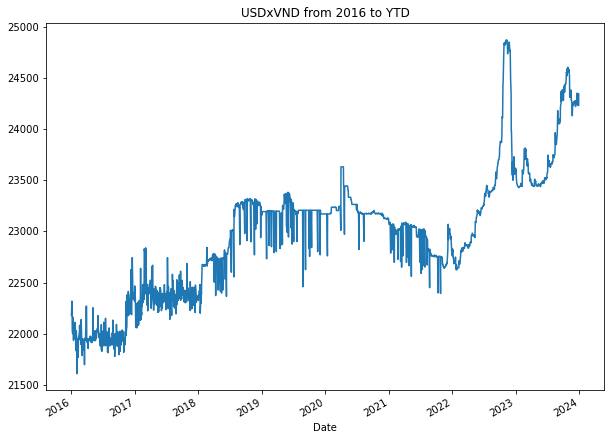

In [168]:
# Get data
data = yf.download('USDVND=X','2016-01-01','2024-01-01') # from 1 Jan 2021 to 31 December 2022

# Plot
data['Adj Close'].plot()
plt.title("USDxVND from 2016 to YTD")
plt.show()


# Stationarity

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.788486879363325
P-Value: 0.20120523655901873
Number of lags: 15
Number of observations: 2069
Critical Values: {'1%': -3.9631522480957244, '5%': -3.4126141072627973, '10%': -3.1283006052584623}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


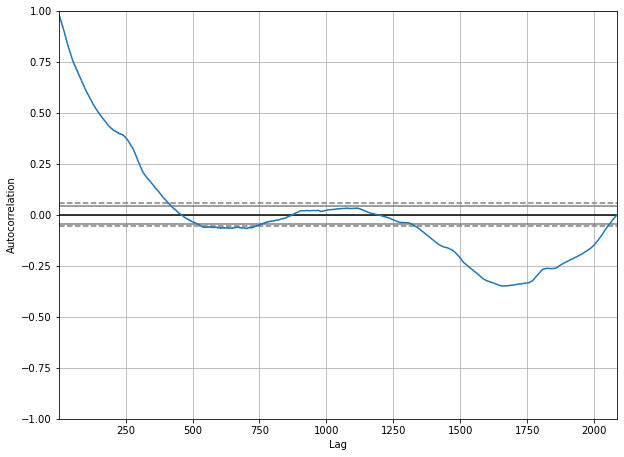

In [169]:
# Check autocorrelation
df = pd.DataFrame(data['Adj Close']) 
autocorrelation_plot(df)

# Check adf
adftest = adfuller(df, autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

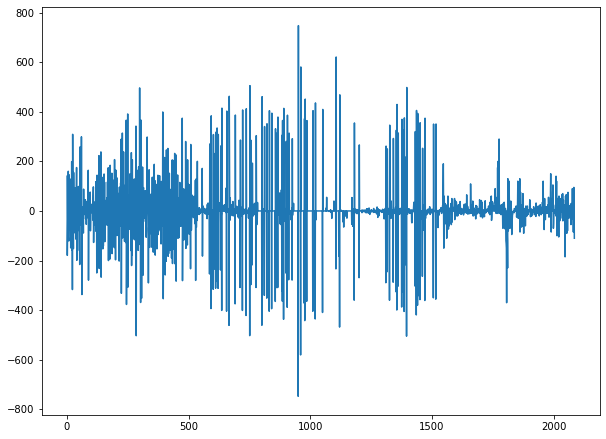

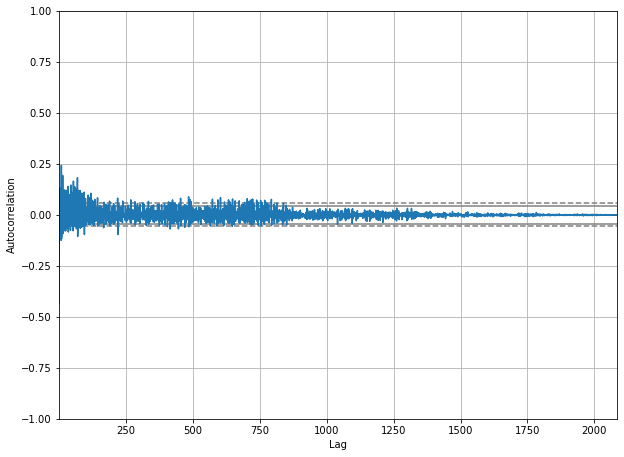

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -12.24622732471399
P-Value: 1.5711729386828928e-19
Number of lags: 14
Number of observations: 2069
Critical Values: {'1%': -3.9631522480957244, '5%': -3.4126141072627973, '10%': -3.1283006052584623}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [172]:
# Apply first order difference
df['diff1'] = df['Adj Close'].diff().dropna()

# line plot
plt.plot(df['diff1'])
plt.show()

autocorrelation_plot(df['diff1'].dropna())
plt.show()

# Check adf
adftest = adfuller(df['diff1'].dropna(), autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

# Forecast

In [173]:
# Separate data into train and test data
df = df.reset_index()
msk = (df.index < len(df)*0.66)
df_train = df['diff1'][msk].copy()
df_test = df['diff1'][~msk].copy()

In [174]:
# Random prediction
predictions = list()
history = df_train['Adj Close'][-1]
for i in range(len(df_test)):
    yhat = history + (-1 if random() < 0.5 else 1)
    predictions.append(yhat)
    history = df_test[i]
error = mean_squared_error(test, predictions)
print('Random MSE: %.3f' % error)

KeyError: 'Adj Close'

In [ ]:
# Random prediction
predictions = list()
history = train[-1]
for i in range(len(test)):
    yhat = history + (-1 if random() < 0.5 else 1)
    predictions.append(yhat)
    history = test[i]
error = mean_squared_error(test, predictions)
print('Random MSE: %.3f' % error)